# **Proyecto: Sistemas de Recomendación**

# **Introducción**

#### Un sistema de recomendación es una herramienta que se usa para sugerir productos o servicios al usuario. Su propósito principal es, a través de una serie de valoraciones y criterios sobre los datos del usuario o del ítem, predecir qué productos o servicios podrían ser del agrado del usuario, con el fin de mejorar su experiencia.


# **Preprocesamiento De Datos**

#### La fase de preprocesamiento de datos es un paso fundamental en cualquier proyecto de análisis de datos o machine learning. Su objetivo es preparar los datos brutos para que sean aptos para el análisis o para alimentar modelos predictivos. Esta fase implica una serie de técnicas y procesos destinados a limpiar, transformar y estructurar los datos.

In [18]:
#Importando librerías necesarias para todo el proyecto
#!pip install wordcloud
import pandas as pd
import numpy as np
from zipfile import ZipFile
from urllib.request import urlopen
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

## **Carga De Datos**

In [19]:
URL = \
    'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# open and save the zip file onto computer
url = urlopen(URL)
output = open('zipFile.zip', 'wb')    # note the flag:  "wb"
output.write(url.read())
output.close()

zip_file = ZipFile('zipFile.zip')
df_links = pd.read_csv(zip_file.open('ml-latest-small/links.csv'))
df_movies = pd.read_csv(zip_file.open('ml-latest-small/movies.csv'))
df_ratings = pd.read_csv(zip_file.open('ml-latest-small/ratings.csv'))
df_tags = pd.read_csv(zip_file.open('ml-latest-small/tags.csv'))

## **Exploración Inicial**

In [20]:
df_list = [df_links,df_movies,df_ratings,df_tags]
df_names = ['df_links','df_movies','df_ratings','df_tags']


for df, name in zip(df_list, df_names):
    df_name = name[3:]
    #Printing top 5 rows
    print(f'DataFrame \033[1m{df_name}\033[0m Top 5 rows')
    display(df.head(5))
    print('\n')
    #Printing DataFrame information (number of rows and columns, data types of each column)
    print(f'\033[1m{df_name}\033[0m DataFrame Information')
    print(df.info())
    print('-------------------------------------------------------------------------\n')


DataFrame links Top 5 rows


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0




links DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None
-------------------------------------------------------------------------

DataFrame movies Top 5 rows


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy




movies DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------------------------------------------------------------------

DataFrame ratings Top 5 rows


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931




ratings DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------------------------------------------------------------------

DataFrame tags Top 5 rows


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200




tags DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None
-------------------------------------------------------------------------



## **Valores Nulos**

In [21]:
#Exploring how many NAs are in DF
for df, name in zip(df_list, df_names):
    df_name = name[3:]
    #Printing sum of NA values by variable
    print(f'Number of NA values in \033[1m{df_name}\033[0m DataFrame')
    print(df.isna().sum())
    print('\n')


Number of NA values in links DataFrame
movieId    0
imdbId     0
tmdbId     8
dtype: int64


Number of NA values in movies DataFrame
movieId    0
title      0
genres     0
dtype: int64


Number of NA values in ratings DataFrame
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Number of NA values in tags DataFrame
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64




In [22]:
print('Debido a que la tabla de links tiene únicamente links de la película hacia otros sitios, no se eliminarán duplicados.')

Debido a que la tabla de links tiene únicamente links de la película hacia otros sitios, no se eliminarán duplicados.


## **Conversión Tipo De Datos**

In [23]:
#Converting Timestamp to Date Format
df_ratings['rating_date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_tags['tag_date'] = pd.to_datetime(df_tags['timestamp'], unit='s')


In [24]:
df_ratings.head()

,userId,movieId,rating,timestamp,rating_date
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


In [25]:
df_tags.head()

,userId,movieId,tag,timestamp,tag_date
0,2,60756,funny,1445714994,2015-10-24 19:29:54
1,2,60756,Highly quotable,1445714996,2015-10-24 19:29:56
2,2,60756,will ferrell,1445714992,2015-10-24 19:29:52
3,2,89774,Boxing story,1445715207,2015-10-24 19:33:27
4,2,89774,MMA,1445715200,2015-10-24 19:33:20


## **Creación de Nuevas Variable year y one hot encoder de generos**

In [26]:
#Extracting Year of Each Movie
df_movies['movie_year'] = df_movies['title'].str.extract(r'\((\d{4})\)').fillna(0).astype(int)
df_movies['title']=df_movies['title'].str.replace(" ",'')
df_movies['title']=df_movies['title'].apply(lambda x: re.sub(r"\((\d{4})\)",'',x))
# Separacion de generos
df_genres=df_movies.genres.str.get_dummies(sep = '|')
df_movies=pd.concat([df_movies, df_genres], axis=1)
print(df_movies.head(5))
print(df_movies.info())

   movieId                   title  \
0        1                ToyStory   
1        2                 Jumanji   
2        3          GrumpierOldMen   
3        4         WaitingtoExhale   
4        5  FatheroftheBridePartII   

                                        genres  movie_year  \
0  Adventure|Animation|Children|Comedy|Fantasy        1995   
1                   Adventure|Children|Fantasy        1995   
2                               Comedy|Romance        1995   
3                         Comedy|Drama|Romance        1995   
4                                       Comedy        1995   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  ...  \
0                   0       0          1          1         1       1  ...   
1                   0       0          1          0         1       0  ...   
2                   0       0          0          0         0       1  ...   
3                   0       0          0          0         0       1  ...   
4       

# **Exploración Inicial y Análisis Del Conjunto De Datos**





## **Word Cloud para los Tags**

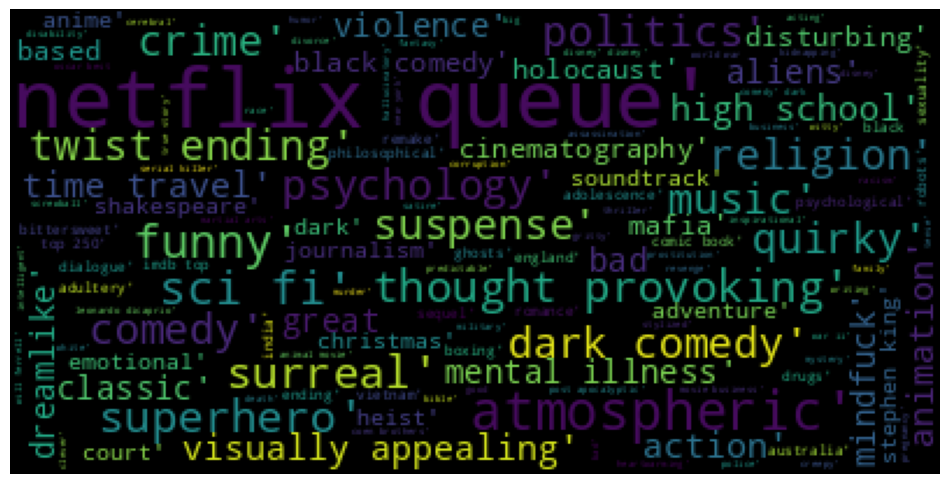

In [27]:
df.tag=df.tag.str.lower()
df.tag=df.tag.str.replace("'",'')
text = df['tag'].to_list()
text_v=[]
for x in text:
  text_v.extend(x.split())
wordcloud = WordCloud().generate(str(text))
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Visualización y exploración de variables numéricas y categóricas**

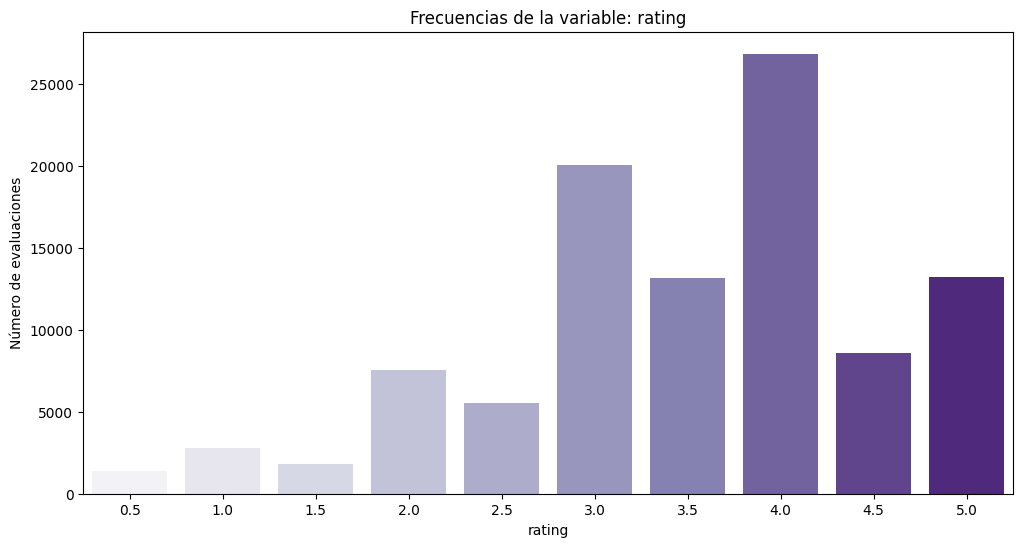

In [28]:
#Visualizando variables

# Variable de ratings
plt.figure(figsize=(12, 6))
sns.countplot(x=df_ratings['rating'], palette='Purples')
plt.title('Frecuencias de la variable: rating')
plt.ylabel('Número de evaluaciones')
plt.show()

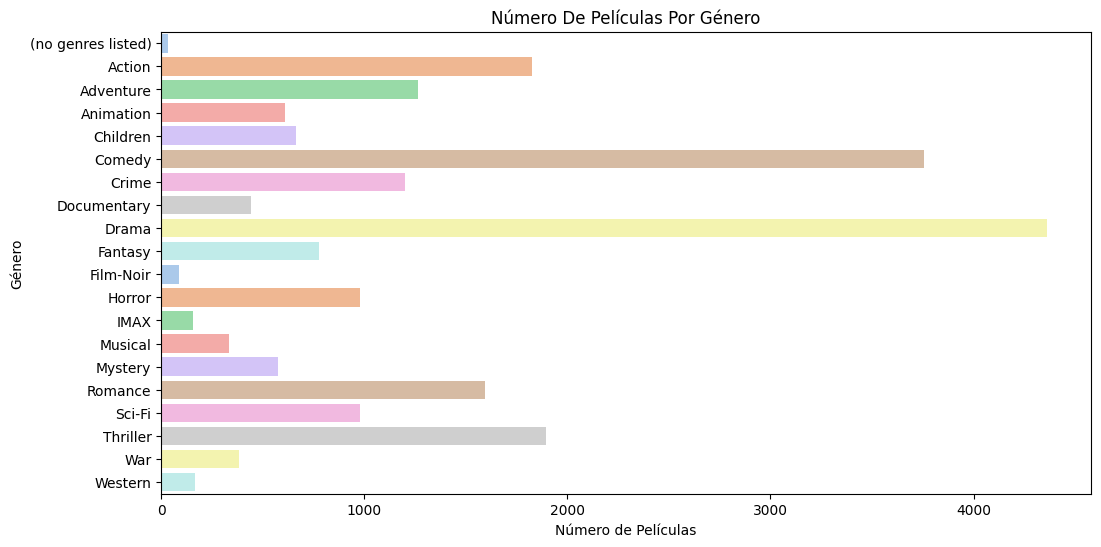

In [29]:
#Visualizando los generos que más películas hay

# Estadísticas Descriptivas
genres_count = df_movies.describe().T.reset_index().loc[:,['index','count','mean']]
genres_count['Número de Películas'] = genres_count['count'] * genres_count['mean']
genres_count = genres_count.iloc[2:,[0,3]]
genres_count.rename(columns={'index':'Género'}, inplace= True)

# Graficando
plt.figure(figsize=(12, 6))
sns.barplot(genres_count, x="Número de Películas", y="Género", palette = 'pastel')
plt.title('Número De Películas Por Género')
plt.show()

Text(0.5, 1.0, 'Box Plot de: año de película')

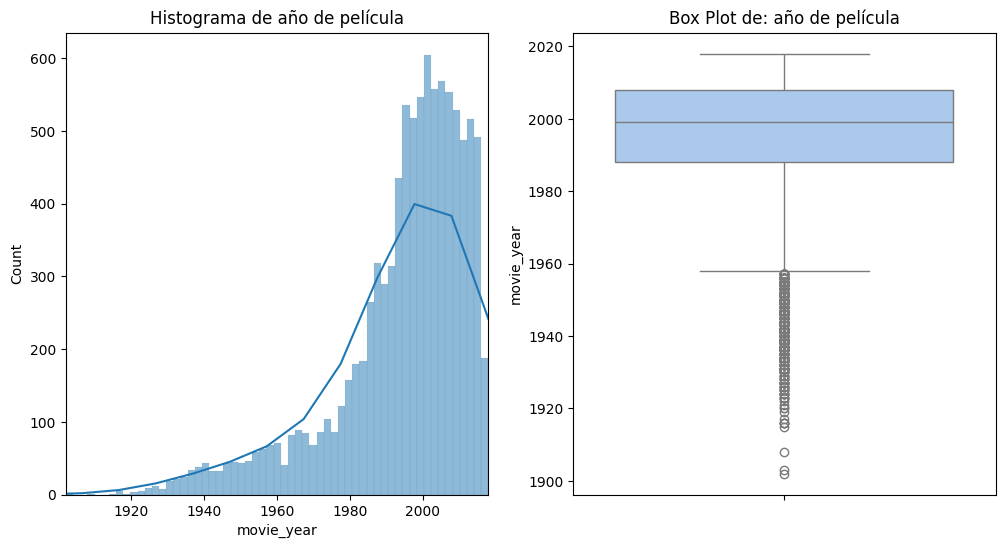

In [30]:
# Visualizando la variable de años de películas
plt.figure(figsize=(12, 6))

# histogram
plt.subplot(1, 2, 1)
sns.histplot(df_movies['movie_year'],kde = True)
plt.xlim(df_movies.loc[df_movies['movie_year'] > 0,['movie_year']].min()[0], df_movies['movie_year'].max())
plt.title("Histograma de año de película")


# box plot
plt.subplot(1, 2, 2)
sns.boxplot(y = df_movies[df_movies['movie_year'] > 0]['movie_year'], palette = "pastel")
plt.title("Box Plot de: año de película")

#plt.show()

Text(0.5, 1.0, 'Box Plot de: timestamp rating')

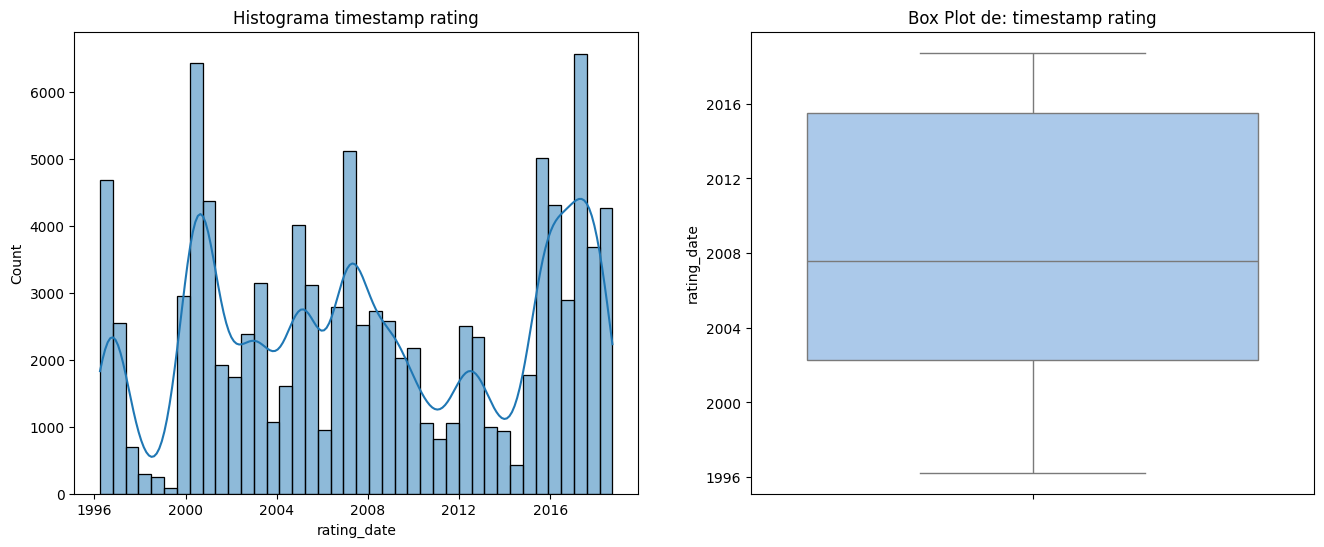

In [31]:
plt.figure(figsize=(16, 6))

# histogram
plt.subplot(1, 2, 1)
sns.histplot(df_ratings['rating_date'],kde = True)
plt.title("Histograma timestamp rating")

# box plot
plt.subplot(1, 2, 2)
sns.boxplot(y = df_ratings['rating_date'], palette = "pastel")
plt.title("Box Plot de: timestamp rating")

Text(0.5, 1.0, 'Box Plot de: timestamp tag')

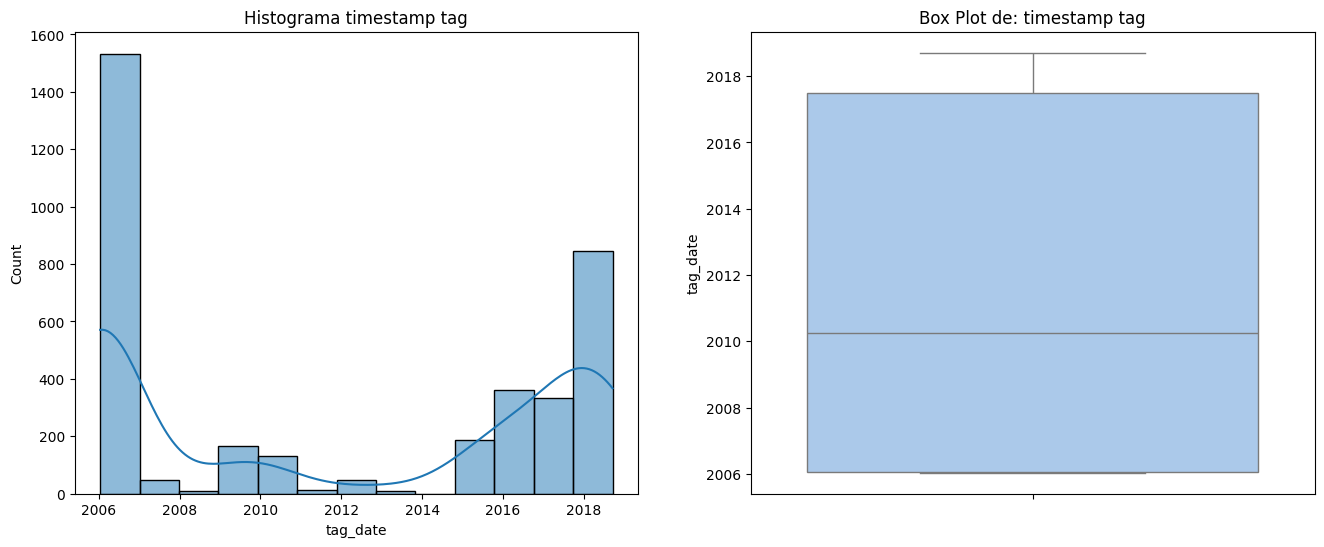

In [32]:
plt.figure(figsize=(16, 6))

# histogram
plt.subplot(1, 2, 1)
sns.histplot(df_tags['tag_date'],kde = True)
plt.title("Histograma timestamp tag")

# box plot
plt.subplot(1, 2, 2)
sns.boxplot(y = df_tags['tag_date'], palette = "pastel")
plt.title("Box Plot de: timestamp tag")

# **Experimentación Con Algoritmos**

## **Colaborative filtering**

fuente: https://nagendranukala.medium.com/collaborative-filtering-similarity-calculations-a974ae4650

In [33]:
# diccionarios de apoyo

movie_id_identifier=dict(zip(df_movies.movieId.to_list(),df_movies.title.to_list()))
movie_id_matrix=dict(zip(df_movies.movieId.unique() ,[x for x in range (len(df_movies.movieId.unique()))]))
matrix_movie_id_identifier=dict(zip( [x for x in range (len(df_movies.movieId.unique()))],df_movies.movieId.unique()))

In [34]:
users=df_ratings.userId.unique().shape[0]
items=len(df_movies.movieId.unique())
data_matrix = np.zeros((users, items))
for line in df_ratings.itertuples():
    #print(line)
    #print(line[1])
    #print(line[2])
    data_matrix[line[1]-1, movie_id_matrix[line[2]] ] = line[3]

for x in range(data_matrix.shape[0]):
    #Normalizar
    data_matrix[x,:]=data_matrix[x,:]/data_matrix[x,:].sum()

#user_similarity = pairwise_distances(data_matrix, metric='cosine')
A_sparse = sparse.csr_matrix(data_matrix)
similar_movies = cosine_similarity(A_sparse.transpose())

def recommendacion(similar_movies,movie_id,movie_id_identifier,movie_id_matrix,matrix_movie_id_identifier):

    print(f"dare una recomendacion basada en {movie_id_identifier[movie_id]}")
    movie_vect=similar_movies[movie_id_matrix[movie_id],:]
    biggest_b_pos = np.argpartition(movie_vect, len(movie_vect)-6)[-6:]
    result = movie_vect[biggest_b_pos]
    nombres_rec=[ movie_id_identifier[matrix_movie_id_identifier[x] ] for x in biggest_b_pos]
    data={'nombres':nombres_rec,"cf de similaridad":result}
    movie_rec=pd.DataFrame(data)
    movie_rec=movie_rec.loc[movie_rec['nombres']!=movie_id_identifier[movie_id]].sort_values(by='cf de similaridad',ascending=False)

    return(movie_rec)

In [35]:
movie_id=1
recommendacion(similar_movies,movie_id,movie_id_identifier,movie_id_matrix,matrix_movie_id_identifier)

# Mientras mas cerca de uno mas similaridad, mientras mas cerca de -1 mas differencias, mas cerca de 0 es indiferente

dare una recomendacion basada en ToyStory


,nombres,cf de similaridad
4,IndependenceDay(a.k.a.ID4),0.486447
3,Twister,0.472941
2,Mission:Impossible,0.460400
1,BrokenArrow,0.454521
0,WillyWonka&theChocolateFactory,0.448069
